In [10]:
from io import StringIO
from pathlib import Path
import numpy as np
import pandas as pd

MODEL_PATH = Path("/scratch/jgut/ProteinMPNN_models/")

#/scratch/jgut/ProteinMPNN_models/ProteinMPNN_finetune_crossentropy_10/output/1ABO_A/seqs/1ABO_A.fa 

def load_distance_matrix(matrix_path:Path):
    alphabet = 'ACDEFGHIKLMNPQRSTVWYX'
    if matrix_path is None:
        identity_matrix = [[0 if ending_letter==starting_letter else 1 for ending_letter in alphabet] for starting_letter in alphabet]
        return identity_matrix
    with open(matrix_path, "r") as f:
        lines = f.readlines()
    lines = r"".join([line for line in lines if line[0]!= "#"]).replace("  ", " ").replace("  ", " ")
    blosum_string = StringIO(lines)
    df = pd.read_csv(blosum_string, sep=" ", index_col=0).to_dict()
    return df

BLOSUM60_DISTANCE = load_distance_matrix("/scratch/jgut/blosum_distance/matrices/blosum62_distance.mat")

def compute_distance(target:str, prediction:str, average=True, distance:dict=BLOSUM60_DISTANCE, exponent:float=1.0):
    output_distance = np.sum([distance[si][sj]**exponent for si,sj in zip(target,prediction)])
    if average:
        return (output_distance/len(target))**float(1./exponent)
    return output_distance**float(1./exponent)

def compute_distance_chars(target:str, prediction:str, distance:dict=BLOSUM60_DISTANCE):
    output_distances = [distance[si][sj] for si,sj in zip(target,prediction)]
    return output_distances

def read_fasta_sequences(fasta_path:Path):
    with open(fasta_path, 'r') as fasta_file:
        lines = [line.strip() for line in fasta_file.readlines()]
    return lines[1], lines[3]

def compute_similarity_score(target:str, prediction:str):
    score = 0
    for it, target_char in enumerate(target):
        if target_char==prediction[it]:
            score+=1
    return score/len(target)

def main():
    scores = []
    char_scores = []
    #ProteinMPNN_finetune_blosum_0.5_1_100000_emd
    char_trans = {}
    for configuration_path in MODEL_PATH.glob("ProteinMPNN_finetune_*longer"):
        print(configuration_path)
        parts = [part for part in str(configuration_path.name).split("_") if part]
        print(parts)
        if len(parts)<7:
            continue
        matrix = parts[2]
        omega = float(parts[3])
        phi = float(parts[4])
        lambd = float(parts[5])
        cont=0
        curr_char_trans = {}
        for example_path in (configuration_path/"output").glob("*"):
            example = example_path.name
            
            if (example_path/"seqs"/f"{example}.fa").exists():
                target_sequence, predicted_sequence = read_fasta_sequences(example_path/"seqs"/f"{example}.fa")
                if cont<10:
                    print(f"targ_seq {target_sequence}")
                    print(f"pred_seq {predicted_sequence}")
                    cont+=1
                similarity_score = compute_similarity_score(target_sequence, predicted_sequence)
                blosum1_distance=compute_distance(target_sequence, predicted_sequence, exponent=1)
                blosum2_distance=compute_distance(target_sequence, predicted_sequence, exponent=2)
                blosum4_distance=compute_distance(target_sequence, predicted_sequence, exponent=4)
                blosum8_distance=compute_distance(target_sequence, predicted_sequence, exponent=8)
                blosum01_distance=compute_distance(target_sequence, predicted_sequence, exponent=0.1)
                blosum16_distance=compute_distance(target_sequence, predicted_sequence, exponent=16)
                blosum32_distance=compute_distance(target_sequence, predicted_sequence, exponent=32)
                scores.append({"omega":omega,"phi":phi,"lambd":lambd, "matrix_type":matrix, "example":example, "similarity_score":similarity_score,
                              "blosum1_distance": blosum1_distance, "blosum2_distance": blosum2_distance, "blosum4_distance": blosum4_distance,"blosum8_distance": blosum8_distance,
                            "blosum01_distance": blosum01_distance, "blosum16_distance": blosum16_distance,"blosum32_distance": blosum32_distance,})

                
                if len(target_sequence) == len(predicted_sequence):
                        # score scores
                    for it, tar_char in enumerate(target_sequence):
                        pred_char = predicted_sequence[it]
                        curr_dict = curr_char_trans.get(tar_char, {})
                        curr_dict[pred_char] = curr_dict.get(pred_char, 0)+1
                        curr_char_trans[tar_char] =curr_dict
                    for it, scor in enumerate(compute_distance_chars(target_sequence[-5:], predicted_sequence[-5:], distance=BLOSUM60_DISTANCE)):
                        char_scores.append({"omega":omega,"phi":phi,"lambd":lambd, "matrix_type":matrix, "example":example,"it":it,"dist":scor})
        print(curr_char_trans)
        char_trans[tuple(parts)] = curr_char_trans
    for beta_path in MODEL_PATH.glob("beta_*"):
        print(beta_path)
        beta = int(str(beta_path.name)[len("beta_"):])
        matrix_type="old"
        for example_path in (beta_path/"output").glob("epoch106_*/*"):
            example = example_path.name
            if (example_path/"seqs"/f"{example}.fa").exists():
                target_sequence, predicted_sequence = read_fasta_sequences(example_path/"seqs"/f"{example}.fa")
                similarity_score = compute_similarity_score(target_sequence, predicted_sequence)
                blosum1_distance=compute_distance(target_sequence, predicted_sequence, exponent=1)
                blosum2_distance=compute_distance(target_sequence, predicted_sequence, exponent=2)
                blosum4_distance=compute_distance(target_sequence, predicted_sequence, exponent=4)
                blosum8_distance=compute_distance(target_sequence, predicted_sequence, exponent=8)
                blosum01_distance=compute_distance(target_sequence, predicted_sequence, exponent=0.1)
                blosum16_distance=compute_distance(target_sequence, predicted_sequence, exponent=16)
                blosum32_distance=compute_distance(target_sequence, predicted_sequence, exponent=32)
                scores.append({"beta":float(beta), "matrix_type":matrix_type, "example":example, "similarity_score":similarity_score,
                              "blosum1_distance": blosum1_distance, "blosum2_distance": blosum2_distance, "blosum4_distance": blosum4_distance,"blosum8_distance": blosum8_distance,
                              "blosum01_distance": blosum01_distance, "blosum16_distance": blosum16_distance,"blosum32_distance": blosum32_distance,})
                if len(target_sequence) == len(predicted_sequence):
                        # score scores
                    for it, tar_char in enumerate(target_sequence):
                        pred_char = predicted_sequence[it]
                        curr_dict = curr_char_trans.get(tar_char, {})
                        curr_dict[pred_char] = curr_dict.get(pred_char, 0)+1
                        curr_char_trans[tar_char] =curr_dict

        print(curr_char_trans)
        char_trans[beta_path] = curr_char_trans
    df = pd.DataFrame(scores)
    char_df = pd.DataFrame(char_scores)       
    return df,char_df, char_trans
df, char_df, char_trans = main()

/scratch/jgut/ProteinMPNN_models/ProteinMPNN_finetune_blosum_0_0.25_4_longer
['ProteinMPNN', 'finetune', 'blosum', '0', '0.25', '4', 'longer']
targ_seq NLFVALYDFVASGDNTLSITKGEKLRVLGYNHNGEWCEAQTKNGQGWVPSNYITPVNS
pred_seq NLYRALEDFEANGNGTLSIKKGELLKLLGKDENGKWWLVETEKGKGWIPADKIEPVGG
targ_seq LFVALYDFVASGDNTLSITKGEKLRVLGYNHNGEWCEAQTKNGQGWVPSNYITPVN
pred_seq MAVALVAVEAGENGELSIRPGEELVVHGGNGDGSWLLVSTAEGEGWVPADAVSPAA
targ_seq SLFVALYDFVASGDNTLSITKGEKLRVLGYNHNGEWCEAQTKNGQGWVPSNYITPVS
pred_seq EKYVGAKALKPESEESLAFEANSDVTVVEWSGSNEVAYGKTKEGEGWVPLSAVKPVA
targ_seq NLFVALYDFVASGDNTLSITKGEKLRVLGYNHNGEWCEAQTKNGQGWVPSNYITPVNS
pred_seq GLYVAKKDFEATGNGTLSIKKGEELKVLGENEDGKWVLVETKKGTGWIPADAIEPKGK
targ_seq TVAAYNLTWKSTNFKTILEWEPKPVNQVYTVQISTKSGDWKSKCFYTTDTECDLTDEIVKDVKQTYLARVFSYPA
pred_seq VVEPYDLEWKTENGHTILTWGPVPVNQVYTVYIRTPTGKWEKFCVNTKETSCDITDFVNKDPSATYEFKVESYAS
targ_seq EPLYENSPEFTPYLETNLGQPTIQSFEQVGTKVNVTVEDERTLVRRNNTFLSLRDVFGKDLIYTLYYWSGKKTAKTNTNEFLIDVDKGENYCFSVQAVIPSRTVNRKSTDSPVECM
pred_seq MPAFTLPPPFDWLR

In [14]:

char_trans[Path('/scratch/jgut/ProteinMPNN_models/beta_150')]

{'N': {'K': 856,
  'G': 896,
  'D': 1816,
  'N': 2526,
  'S': 1108,
  'T': 624,
  'A': 499,
  'P': 459,
  'L': 270,
  'E': 957,
  'I': 162,
  'Q': 354,
  'C': 65,
  'R': 471,
  'H': 466,
  'Y': 386,
  'V': 390,
  'F': 210,
  'M': 189,
  'W': 106},
 'L': {'L': 11363,
  'K': 1366,
  'V': 1523,
  'A': 647,
  'I': 1988,
  'E': 953,
  'S': 523,
  'T': 769,
  'R': 489,
  'D': 219,
  'W': 178,
  'Y': 380,
  'F': 644,
  'Q': 353,
  'M': 1243,
  'G': 214,
  'H': 267,
  'N': 312,
  'C': 76,
  'P': 273},
 'F': {'Y': 1582,
  'A': 478,
  'V': 495,
  'T': 314,
  'W': 218,
  'G': 227,
  'E': 320,
  'K': 396,
  'F': 4621,
  'S': 361,
  'L': 959,
  'I': 468,
  'R': 263,
  'D': 242,
  'C': 69,
  'H': 279,
  'N': 164,
  'P': 257,
  'Q': 165,
  'M': 382},
 'V': {'R': 442,
  'E': 608,
  'L': 1141,
  'V': 6127,
  'I': 2334,
  'G': 168,
  'A': 433,
  'C': 60,
  'N': 174,
  'P': 274,
  'K': 716,
  'T': 754,
  'D': 177,
  'S': 443,
  'Y': 225,
  'F': 331,
  'M': 494,
  'Q': 267,
  'W': 115,
  'H': 257},
 'A': 

In [29]:
BLOSUM60_DISTANCE = load_distance_matrix("/scratch/jgut/blosum_distance/matrices/blosum62_distance.mat")
for start_letter in starts:
    print(f"{start_letter}: {sum([BLOSUM60_DISTANCE[start_letter][end_char] for end_char in starts]) }")

C: 173
S: 104
T: 117
A: 109
G: 145
P: 155
D: 133
E: 117
Q: 114
N: 129
H: 149
R: 123
K: 119
M: 115
I: 119
L: 116
V: 115
W: 195
Y: 139
F: 138


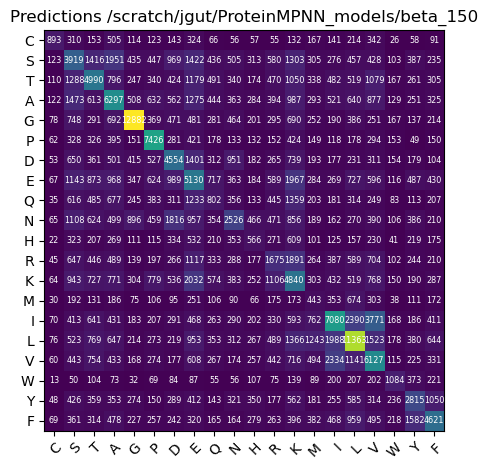

In [18]:
import matplotlib.pyplot as plt
starts = ["C", "S", "T", "A", "G", "P", "D", "E", "Q", "N", "H", "R", "K", "M", "I", "L", "V", "W", "Y", "F"] #list(output_probas.keys())
ends = ["C", "S", "T", "A", "G", "P", "D", "E", "Q", "N", "H", "R", "K", "M", "I", "L", "V", "W", "Y", "F"] #list(output_probas.keys())

fig, ax = plt.subplots()
dikts = char_trans[Path('/scratch/jgut/ProteinMPNN_models/beta_150')]
probas = [[dikts[start][end] for end in ends] for start in starts]

im = ax.imshow(probas)

# Show all ticks and label them with the respective list entries
ax.set_xticks(range(len(ends)), labels=ends,
              rotation=45, ha="right", rotation_mode="anchor")
ax.set_yticks(range(len(starts)), labels=starts)

# Loop over data dimensions and create text annotations.
for i in range(len(starts)):
    for j in range(len(ends)):
        text = ax.text(j, i, f"{probas[i][j]:.0f}",
                       ha="center", va="center", color="w", size='xx-small')

ax.set_title(f"Predictions {Path('/scratch/jgut/ProteinMPNN_models/beta_150')}")
fig.tight_layout()
plt.show()

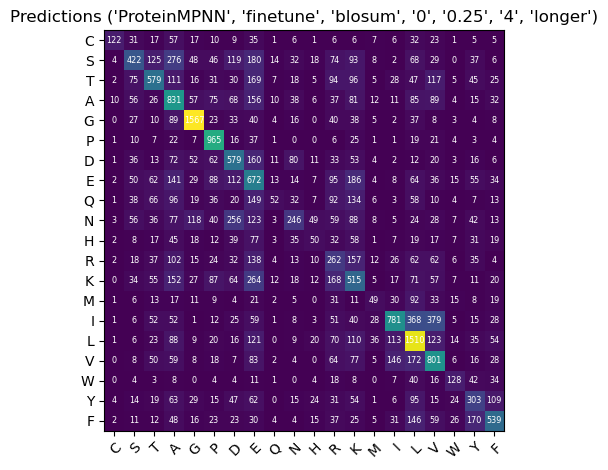

In [22]:
name = tuple(['ProteinMPNN', 'finetune', 'blosum', '0', '0.25', '4', 'longer'])
fig, ax = plt.subplots()
dikts = char_trans[name]
probas = [
    [
        dikts[start][end] if start in dikts and end in dikts[start] else 0
        for end in ends
    ]
    for start in starts
]
im = ax.imshow(probas)

# Show all ticks and label them with the respective list entries
ax.set_xticks(range(len(ends)), labels=ends,
              rotation=45, ha="right", rotation_mode="anchor")
ax.set_yticks(range(len(starts)), labels=starts)

# Loop over data dimensions and create text annotations.
for i in range(len(starts)):
    for j in range(len(ends)):
        text = ax.text(j, i, f"{probas[i][j]:.0f}",
                       ha="center", va="center", color="w", size='xx-small')

ax.set_title(f"Predictions {name}")
fig.tight_layout()
plt.show()

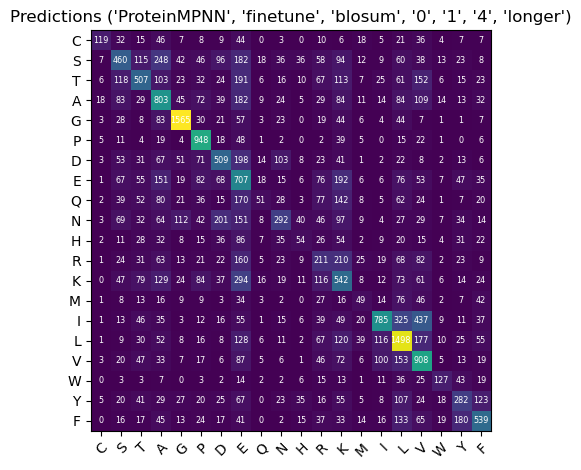

In [23]:
name = tuple(['ProteinMPNN', 'finetune', 'blosum', '0', '1', '4', 'longer'])
fig, ax = plt.subplots()
dikts = char_trans[name]
probas = [
    [
        dikts[start][end] if start in dikts and end in dikts[start] else 0
        for end in ends
    ]
    for start in starts
]
im = ax.imshow(probas)

# Show all ticks and label them with the respective list entries
ax.set_xticks(range(len(ends)), labels=ends,
              rotation=45, ha="right", rotation_mode="anchor")
ax.set_yticks(range(len(starts)), labels=starts)

# Loop over data dimensions and create text annotations.
for i in range(len(starts)):
    for j in range(len(ends)):
        text = ax.text(j, i, f"{probas[i][j]:.0f}",
                       ha="center", va="center", color="w", size='xx-small')

ax.set_title(f"Predictions {name}")
fig.tight_layout()
plt.show()

In [2]:
char_df

,omega,phi,lambd,matrix_type,example,it,dist
0,0.0,0.25,4.0,blosum,1ABO_A,0,6
1,0.0,0.25,4.0,blosum,1ABO_A,1,0
2,0.0,0.25,4.0,blosum,1ABO_A,2,0
3,0.0,0.25,4.0,blosum,1ABO_A,3,6
4,0.0,0.25,4.0,blosum,1ABO_A,4,5
...,...,...,...,...,...,...,...
2835,0.0,2.00,4.0,blosum,3EGU_A,0,0
2836,0.0,2.00,4.0,blosum,3EGU_A,1,0
2837,0.0,2.00,4.0,blosum,3EGU_A,2,6
2838,0.0,2.00,4.0,blosum,3EGU_A,3,0


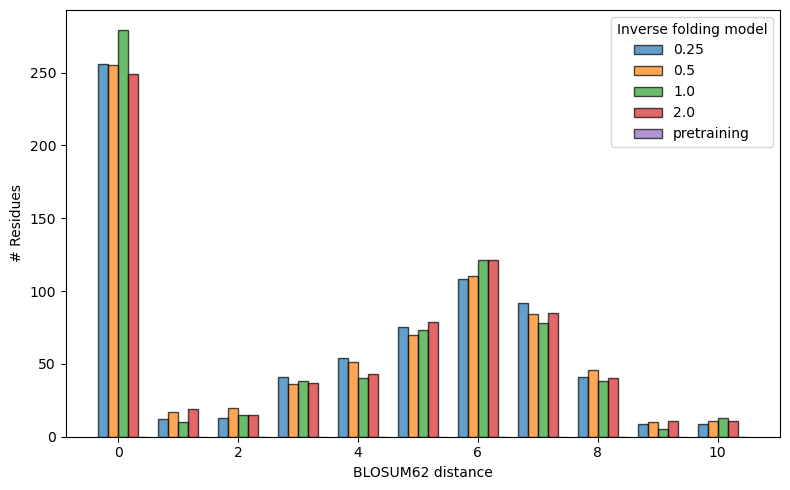

In [4]:
import matplotlib.pyplot as plt
model_score = {}
for phi in char_df.phi.unique():
    model_score[phi], _=np.histogram(char_df[(char_df.phi==phi) &(char_df.matrix_type=="blosum")]["dist"], bins=list(range(12)))
model_score["pretraining"], _ = np.histogram(char_df[char_df.matrix_type=="pretraining"]["dist"], bins=list(range(12)))
# Plot as bar chart
plt.figure(figsize=(8, 5))
bin_centers = [bin_center-(1/2)+1/4 for bin_center in range(12)]
for it, model in enumerate(model_score.keys()):
    plt.bar([bin_center+(it/(len(model_score)+1)) for bin_center in bin_centers[0:-1]], model_score[model], width=1/(len(model_score)+1), edgecolor='black', alpha=0.7, label=model)
plt.legend(title="Inverse folding model")
plt.xlabel('BLOSUM62 distance')
plt.ylabel('# Residues')
plt.tight_layout()
plt.show()

In [11]:
df[df.example=="1ABO_A"]

,omega,phi,lambd,matrix_type,example,similarity_score,blosum1_distance,blosum2_distance,blosum4_distance,blosum8_distance,blosum01_distance,blosum16_distance,blosum32_distance
0,0.0,0.5,4.0,blosum,1ABO_A,0.448276,2.896552,4.097939,5.069834,5.878455,0.012849,6.604870,7.208787
142,0.0,2.0,4.0,blosum,1ABO_A,0.448276,2.965517,4.246703,5.536435,7.352847,0.013225,9.311877,10.569980
284,0.0,1.0,4.0,blosum,1ABO_A,0.448276,2.775862,3.906228,4.852459,5.713680,0.012548,6.547234,7.204193
426,0.0,1.0,0.0,pretraining,1ABO_A,0.534483,2.568966,4.006460,5.448539,7.345844,0.002481,9.311859,10.569980


In [39]:
cut_df = df[((df.phi==0.5) &(df.matrix_type=="blosum"))|(df.matrix_type=="pretraining")]
for example in cut_df.example.unique():
    print(cut_df[cut_df.example==example][["phi","matrix_type","example","similarity_score"]] )
    

     phi  matrix_type example  similarity_score
0    0.5       blosum  1ABO_A          0.448276
426  1.0  pretraining  1ABO_A          0.534483
     phi  matrix_type example  similarity_score
1    0.5       blosum  1ABQ_A          0.428571
427  1.0  pretraining  1ABQ_A          0.482143
     phi  matrix_type example  similarity_score
2    0.5       blosum  1AWO_A          0.245614
428  1.0  pretraining  1AWO_A          0.210526
     phi  matrix_type example  similarity_score
3    0.5       blosum  1BBZ_A               0.5
429  1.0  pretraining  1BBZ_A               0.5
     phi  matrix_type example  similarity_score
4    0.5       blosum  1DAN_T          0.413333
430  1.0  pretraining  1DAN_T          0.440000
     phi  matrix_type example  similarity_score
5    0.5       blosum  1DAN_U          0.396552
431  1.0  pretraining  1DAN_U          0.413793
     phi  matrix_type example  similarity_score
6    0.5       blosum  1GBQ_A          0.385965
432  1.0  pretraining  1GBQ_A          0

In [81]:
cut2_df = cut_df[((cut_df.phi==0.5) &(cut_df.matrix_type=="blosum"))][["phi","example"]]
cut2_df["diff"] = cut_df[((cut_df.phi==0.5) &(cut_df.matrix_type=="blosum"))]["similarity_score"]-cut_df[cut_df.matrix_type=="pretraining"].reset_index()["similarity_score"]
cut2_df

,phi,example,diff
0,0.5,1ABO_A,-0.086207
1,0.5,1ABQ_A,-0.053571
2,0.5,1AWO_A,0.035088
3,0.5,1BBZ_A,0.000000
4,0.5,1DAN_T,-0.026667
...,...,...,...
137,0.5,3EG1_A,0.000000
138,0.5,3EG1_B,-0.035714
139,0.5,3EG2_A,0.047619
140,0.5,3EG3_A,0.000000


In [57]:
cut2_df.sort_values("diff")
#blosum-pretraining

,phi,example,diff
110,0.5,5LV6_A,-0.181818
111,0.5,5LV6_B,-0.159091
24,0.5,1SSU_A,-0.098039
86,0.5,4J9I_A,-0.089286
48,0.5,2GBQ_A,-0.087719
...,...,...,...
14,0.5,1KKL_J,0.068182
40,0.5,2DSQ_G,0.068493
87,0.5,4JJB_A,0.070175
107,0.5,5IEB_A,0.076271


In [58]:
sum(cut2_df["diff"])

-1.2678163555718138

In [54]:
cut_df[cut_df.matrix_type=="pretraining"].reset_index()["similarity_score"]

0      0.534483
1      0.482143
2      0.210526
3      0.500000
4      0.440000
         ...   
137    0.517241
138    0.535714
139    0.444444
140    0.492063
141    0.473684
Name: similarity_score, Length: 142, dtype: float64

<Axes: xlabel='similarity_score', ylabel='Count'>

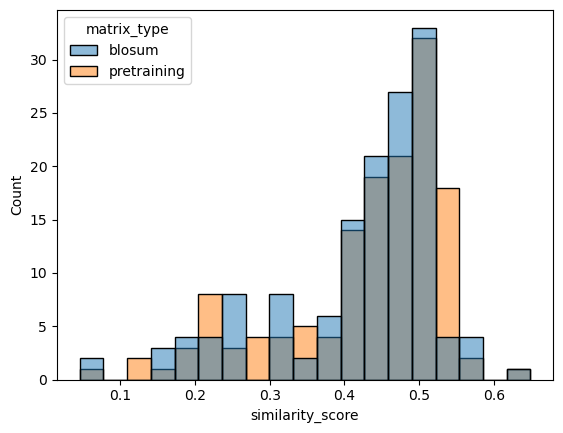

In [43]:
sns.histplot(cut_df,hue="matrix_type", x="similarity_score")

,omega,phi,lambd,matrix_type,similarity_score,blosum1_distance,blosum2_distance,blosum4_distance,blosum8_distance,blosum01_distance,blosum16_distance,blosum32_distance
284,0.0,1.0,4.0,blosum,0.448276,2.775862,3.906228,4.852459,5.713680,0.012548,6.547234,7.204193
285,0.0,1.0,4.0,blosum,0.375000,3.142857,4.305312,5.404216,6.454372,0.041699,7.398532,8.116025
286,0.0,1.0,4.0,blosum,0.245614,4.052632,4.943541,5.777957,6.740701,0.299393,7.884418,8.822853
287,0.0,1.0,4.0,blosum,0.534483,2.362069,3.655416,4.791488,5.765436,0.002289,6.581383,7.207233
288,0.0,1.0,4.0,blosum,0.533333,2.626667,4.110150,5.442223,6.647061,0.002538,7.787708,8.748337
...,...,...,...,...,...,...,...,...,...,...,...,...
563,0.0,1.0,0.0,pretraining,0.517241,2.327586,3.525767,4.568853,5.480744,0.003143,6.323400,7.052947
564,0.0,1.0,0.0,pretraining,0.535714,2.232143,3.451190,4.533693,5.502226,0.002122,6.359923,7.063571
565,0.0,1.0,0.0,pretraining,0.444444,2.920635,4.109609,5.122444,6.021634,0.014022,6.790537,7.342876
566,0.0,1.0,0.0,pretraining,0.492063,2.730159,4.019792,5.115759,6.044127,0.005842,6.800353,7.343658


In [27]:
df = df.drop("example", axis=1)
df.groupby(["omega","phi","lambd","matrix_type"]).agg("median")

similarity_score  blosum1_distance  \
omega phi lambd matrix_type                                       
0.0   0.5 4.0   blosum               0.454267          2.796552   
      1.0 0.0   pretraining          0.469071          2.739155   
          4.0   blosum               0.459184          2.730367   
      2.0 4.0   blosum               0.445702          2.842188   

                             blosum2_distance  blosum4_distance  \
omega phi lambd matrix_type                                       
0.0   0.5 4.0   blosum               4.081101          5.330130   
      1.0 0.0   pretraining          4.020144          5.255116   
          4.0   blosum               4.055949          5.319672   
      2.0 4.0   blosum               4.157193          5.379278   

                             blosum8_distance  blosum01_distance  \
omega phi lambd matrix_type                                        
0.0   0.5 4.0   blosum               6.588448           0.011161   
      1.0 0.0   pretraining          6.490081           0.008382   
          4.0   blosum               6.616871           0.009845   
      2.0 4.0   blosum               6.654449           0.013212   

                             blosum16_distance  blosum32_distance  
omega phi lambd matrix_type                                        
0.0   0.5 4.0   blosum                7.899773           8.956708  
      1.0 0.0   pretraining           7.793413           8.806211  
          4.0   blosum                7.884980           8.927090  
      2.0 4.0   blosum                7.997322           9.204164

In [3]:
df.groupby(["omega","phi","lambd","matrix_type"]).agg("mean")

similarity_score  blosum1_distance  \
omega phi lambd matrix_type                                       
0.0   0.5 4.0   blosum               0.420380          3.047646   
      1.0 0.0   pretraining          0.429308          2.966913   
          4.0   blosum               0.423449          3.004573   
      2.0 4.0   blosum               0.415455          3.058346   

                             blosum2_distance  blosum4_distance  \
omega phi lambd matrix_type                                       
0.0   0.5 4.0   blosum               4.252384          5.373709   
      1.0 0.0   pretraining          4.175857          5.301270   
          4.0   blosum               4.208197          5.335789   
      2.0 4.0   blosum               4.271527          5.422222   

                             blosum8_distance  blosum01_distance  \
omega phi lambd matrix_type                                        
0.0   0.5 4.0   blosum               6.547073           0.135128   
      1.0 0.0   pretraining          6.468943           0.103696   
          4.0   blosum               6.523969           0.134995   
      2.0 4.0   blosum               6.684243           0.096820   

                             blosum16_distance  blosum32_distance  
omega phi lambd matrix_type                                        
0.0   0.5 4.0   blosum                7.800849           8.829714  
      1.0 0.0   pretraining           7.701595           8.699205  
          4.0   blosum                7.796386           8.831490  
      2.0 4.0   blosum                8.043435           9.114559

In [4]:
agg_df = (
    df[["beta", "matrix_type", "similarity_score","blosum1_distance","blosum2_distance","blosum4_distance","blosum8_distance"]].groupby(["beta", "matrix_type"])
      .agg("mean")
      .reset_index()
)

KeyError: "['beta'] not in index"

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
agg_df = (
    df[["beta", "matrix_type", "similarity_score","blosum1_distance","blosum2_distance","blosum4_distance","blosum8_distance"]].groupby(["beta", "matrix_type"])
      .agg("mean")
      .reset_index()
)
scores = ["similarity_score","blosum1_distance","blosum2_distance","blosum4_distance","blosum8_distance"]
for score in scores:
    sns.lineplot(data=agg_df, x="beta", y=score, hue="matrix_type", palette="tab10")
    plt.show()

KeyError: "['beta'] not in index"

In [6]:
agg_df = (
    df[["beta", "matrix_type", "similarity_score","blosum1_distance","blosum2_distance","blosum4_distance","blosum8_distance"]].groupby(["beta", "matrix_type"])
      .agg("count")
      .reset_index()
)
agg_df

,beta,matrix_type,similarity_score,blosum1_distance,blosum2_distance,blosum4_distance,blosum8_distance
0,0.0,0.000001_re,142,142,142,142,142
1,0.0,0.0001_re,142,142,142,142,142
2,0.0,0.001_re,142,142,142,142,142
3,0.0,old,142,142,142,142,142
4,5.0,0.000001_re,142,142,142,142,142
5,5.0,0.0001_re,142,142,142,142,142
6,5.0,0.001_re,142,142,142,142,142
7,5.0,old,142,142,142,142,142
8,10.0,old,142,142,142,142,142
9,20.0,old,142,142,142,142,142
